In this problem, we are given n stocks to chose everyday during the m-day period and want to maximize the total return. Here I first assume the stock return is stationary and I use epsilon-greedy bandit method:

In [117]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import math
import pandas as pd

In [118]:
def stock_return_generate(m, n, standard_deviation = 0.1):
    stock_returns = []
    stock_mean_returns = list(np.random.uniform(-1, 1, n))
    for i in range(n):
        stock_return = np.random.standard_t(3, size = m)
        stock_return = np.array(stock_return)*standard_deviation + stock_mean_returns[i]
        stock_returns.append(stock_return)
    stock_returns = np.array(stock_returns)
    return stock_returns, stock_mean_returns

In [119]:
def get_optimal_price(stock_mean_returns):
    return stock_mean_returns.index(max(stock_mean_returns))

In the epsilon greedy algorithm, the agent have probability $\epsilon$ to choose a stock randomly from the basket or pick the stock with the maximum estimated average return with probability $1-\epsilon$. The estimated average return is equal to the average of all the real returns we got for each stock. 

The updating step for the estimated average return is the following:
$$
\begin{align}
Q_{t}(a) = Q_{t-1}(a) + (R_{t}(a) - Q_{t-1}(a))/t
\end{align}
$$
where $Q_{t}(a)$ is the estimated average return for stock a at round t, $R_{t}(a)$ is the real return we get after we pick the stock a.

I also implement the constant step size $\epsilon$-greedy method where $\frac{1}{t}$ is replaced by $\frac{1}{c}$ where c is a fixed number.

In [120]:
class epsilon_greedy_agent():
    def __init__(self, epsilon, m, n, constant_step = -1):
        self.stock_number = n
        self.round_number = m
        self.epsilon = epsilon
        self.estimated_price_return = [0]*n
        self.stock_chosen_time = [0]*n
        self.regret_value = 0
        self.average_return = 0
        self.average_return_history = []
        self.regret_value_history = []
        self.cummulative_return = []
        self.mode = 'stationary_mean'
        if constant_step > -1:
            self.mode = 'non_stationary_mean'
        self.constant_step = constant_step
        
    def pick_stock(self):
        number1 = random.uniform(0, 1)
        if number1 <= self.epsilon:
            chosen_stock = random.randrange(self.stock_number)
        else:
            chosen_stock = self.estimated_price_return.index(max(self.estimated_price_return))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, i):
        self.stock_chosen_time[chosen_stock] += 1
        if self.mode == 'stationary_mean':
            self.estimated_price_return[chosen_stock] += (stock_values[chosen_stock] - self.estimated_price_return[chosen_stock])/self.stock_chosen_time[chosen_stock]
        if self.mode == 'non_stationary_mean':
            self.estimated_price_return[chosen_stock] += (stock_values[chosen_stock] - self.estimated_price_return[chosen_stock])/self.constant_step
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return += (stock_values[chosen_stock] - self.average_return)/i
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*i)

In [121]:
def epsilon_greedy(m, epsilon, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock, constant_step = -1):
    investor_1 = epsilon_greedy_agent(epsilon, m, n, constant_step = -1)
    for i in range(m):
        chosen_stock = investor_1.pick_stock()
        stock_values = stock_returns[:, i]
        investor_1.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_1.average_return_history, investor_1.regret_value_history, investor_1.cummulative_return

In [122]:
def visualization(m, n):
    steps = list(range(m))
    average_returns = []
    regret_values = []
    standard_deviation = 0.1
    upper_bound_epsilon = pow(m, -1/3)*pow(n*math.log(m), 1/3)
    epsilons = [ 0, 0.05, 0.1, upper_bound_epsilon]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(epsilons)):
        average_return_, regret_value_ = epsilon_greedy(m, epsilons[j], n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)[:2]
        average_returns.append(average_return_)
        regret_values.append(regret_value_)
        
    plt.figure(1)
    for j in range(len(epsilons)):
        plt.plot(steps, average_returns[j], label = f'epsilon = {epsilons[j]}')
        plt.title('Average Return for Epsilon-greedy Method vs steps')
        plt.xlabel('steps')
        plt.ylabel('average return')
        plt.legend()
    
    plt.figure(2)
    for j in range(len(epsilons)):
        plt.plot(steps, regret_values[j], label = f'epsilon = {epsilons[j]}')
        plt.title('Regret Value for Rpsilon-greedy Method vs steps')
        plt.xlabel('steps')
        plt.ylabel('regret value')
        plt.legend()
    

<IPython.core.display.Javascript object>


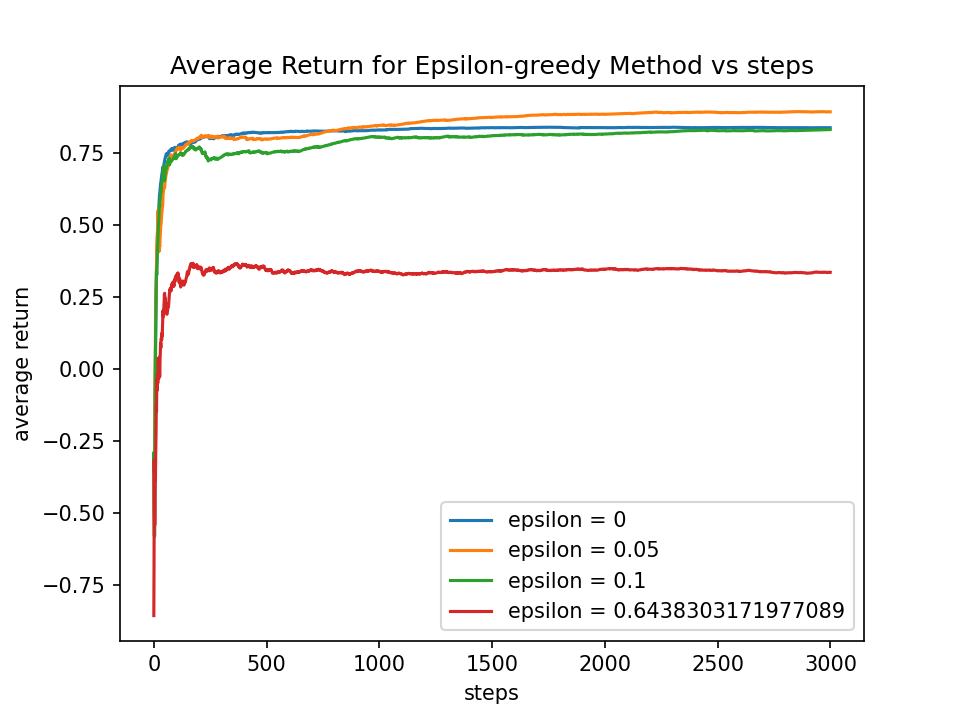

<IPython.core.display.Javascript object>


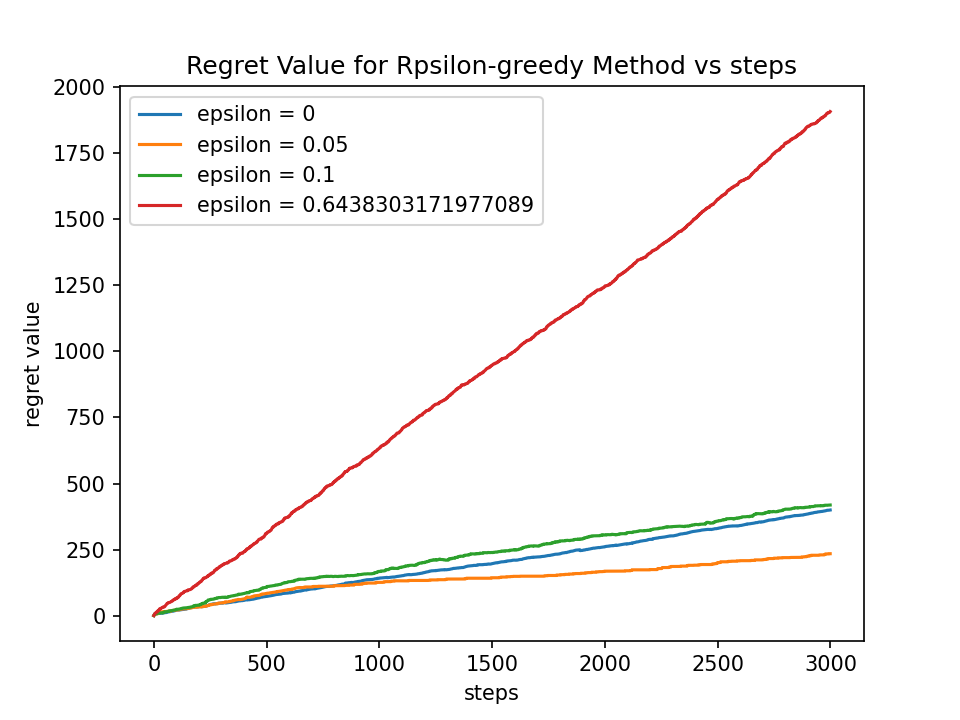

In [123]:
visualization(3000, 100)

Here I also implement the Upper Confidence Bound method for this question. The UCB1 method do not require the mean of stock return to be stationary. Note according to UCB, the value function is 
$$\begin{align}
V_{t} = Q_{t}(a) + c*\sqrt{\frac{ln(t)}{N_{t}(a)}}
\end{align}
$$
where t is the number of rounds, c is the degree of exploration, $Q_{t}(a)$ is the estimated average return for stock a, $N_{t}(a)$ is the number we pick the stock and $V_{t}$ is the value of stock a at time t.

In [124]:
class ucb_agent():
    def __init__(self, n, c):
        self.stock_number = n
        self.degree_of_exploration = c
        self.stock_estimated_value = [0]*n
        self.stock_estimated_return = [0]*n
        self.stock_chosen_number = [0]*n
        self.regret_value = 0
        self.average_return = 0
        self.regret_value_history = []
        self.average_return_history = []
        self.cummulative_return = []
    
    def pick_stock(self):
        chosen_stock = self.stock_estimated_value.index(max(self.stock_estimated_value))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, t):
        self.stock_chosen_number[chosen_stock] += 1
        self.stock_estimated_return[chosen_stock] += (stock_values[chosen_stock] - self.stock_estimated_return[chosen_stock])/self.stock_chosen_number[chosen_stock]
        for i in range(self.stock_number):
            if self.stock_chosen_number[i] > 0:
                self.stock_estimated_value[i] = self.stock_estimated_return[i] + self.degree_of_exploration*math.sqrt(np.log(t)/self.stock_chosen_number[i])
            else:
                self.stock_estimated_value[i] = 100
        self.average_return += (stock_values[chosen_stock] - self.average_return)/t
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*t)

In [125]:
def ucb(m, c, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock):
    investor_2 = ucb_agent(n, c)
    for i in range(m):
        chosen_stock = investor_2.pick_stock()
        stock_values = stock_returns[:, i]
        investor_2.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_2.average_return_history, investor_2.regret_value_history, investor_2.cummulative_return

In [126]:
def visualization_1(m, n):
    steps = list(range(m))
    average_returns = []
    regret_function_values = []
    standard_deviation = 1
    degree_of_exploration = [ 0.01, 0.02, 0.03, 0.05]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(degree_of_exploration)):
        average_return_, regret_function_value_ = ucb(m, degree_of_exploration[j], n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)[:2]
        average_returns.append(average_return_)
        regret_function_values.append(regret_function_value_)
        
    plt.figure(3)
    for j in range(len(degree_of_exploration)):
        plt.plot(steps, average_returns[j], label = f'degree_of_exploration = {degree_of_exploration[j]}')
        plt.title('Average Return for UCB Method vs Steps')
        plt.xlabel('steps')
        plt.ylabel('average return')
        plt.legend()
    
    plt.figure(4)
    for j in range(len(degree_of_exploration)):
        plt.plot(steps, regret_function_values[j], label = f'degree_of_exploration = {degree_of_exploration[j]}')
        plt.title('Regret Value for UCB Method vs steps')
        plt.xlabel('steps')
        plt.ylabel('regret value')
        plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


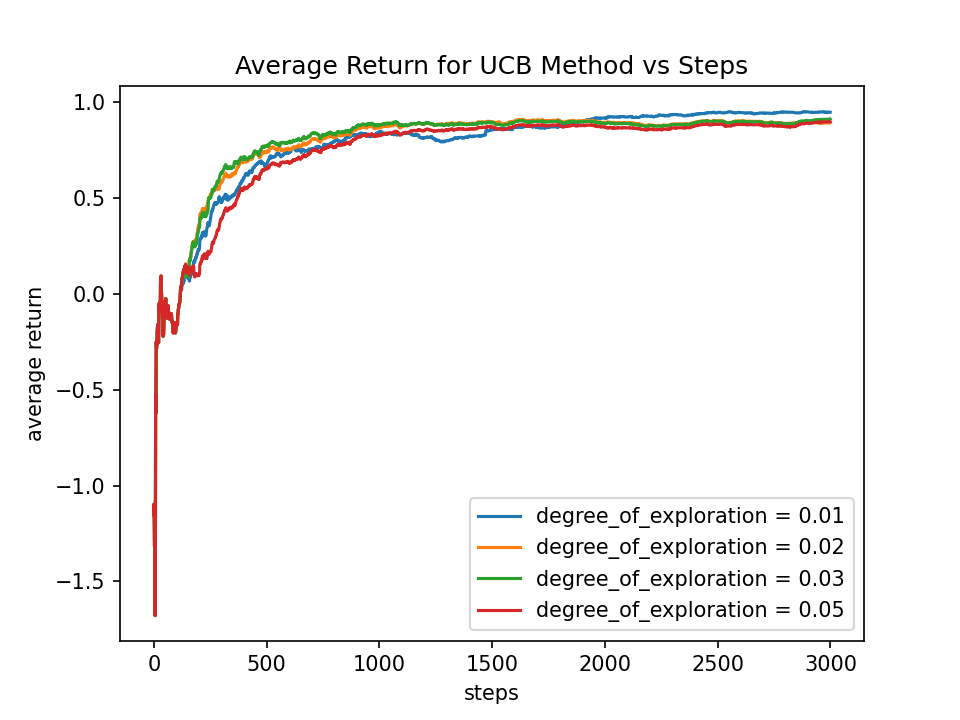

<IPython.core.display.Javascript object>


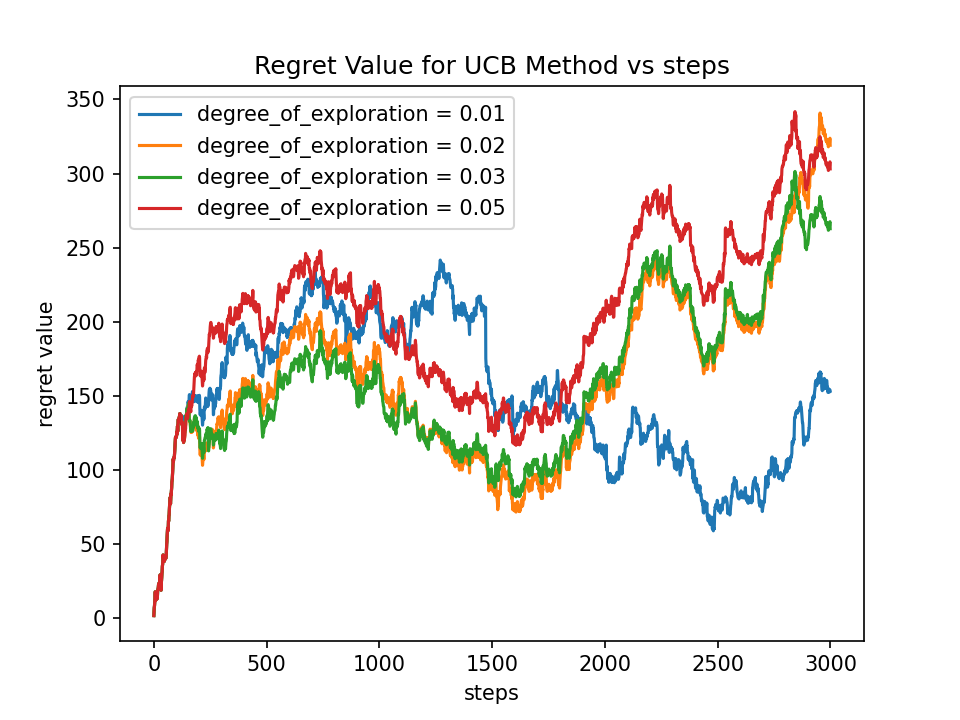

In [127]:
visualization_1(3000, 100)

Next I implement the gradient bandit algorithm for this problem. We let the probability of picking up a stock a to be 
$$
\begin{align}
P[A_{t} = a] = \frac{e^{H_{t}(a)}}{\sum_{b=1}^{n}e^{H_{t}(b)}} = \pi_{t}(a)
\end{align}
$$
where preference value $H_{t}(a) = 0$ when $t = 0$ and
$$
H_{t+1}(a) = H_{t}(a) + \alpha(R_{t} - \bar{R_{t}})(1-\pi_{t}(a)) \\
H_{t+1}(b) = H_{t}(b) + \alpha(R_{t} - \bar{R_{t}})\pi_{t}(b)
$$
where b not equal to a, $\bar{R_{t}}$ is the average return till time t.

In [128]:
class gradient_agent():
    def __init__(self, n, a):
        self.stock_number = n
        self.degree_of_exploration = a
        self.stock_preference_value = [0]*n
        self.stock_probability = [1/n]*n
        self.regret_value = 0
        self.average_return = 0
        self.regret_value_history = []
        self.average_return_history = []
        self.cummulative_return = []
    
    def pick_stock(self):
        chosen_stock = np.random.choice(list(range(self.stock_number)), p = self.stock_probability)
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, t):
        for i in range(self.stock_number):
            if i == chosen_stock:
                self.stock_preference_value[i] += self.degree_of_exploration*(1-self.stock_probability[i])*(stock_values[chosen_stock] - self.average_return)
            else:
                self.stock_preference_value[i] += self.degree_of_exploration*self.stock_probability[i]*(stock_values[chosen_stock] - self.average_return)
        for i in range(self.stock_number):
            self.stock_probability[i] = math.exp(self.stock_preference_value[i])/np.sum(np.exp(self.stock_preference_value))
        self.average_return += (stock_values[chosen_stock] - self.average_return)/t
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*t)

In [129]:
def gradient(m, a, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock):
    investor_3 = gradient_agent(n, a)
    for i in range(m):
        chosen_stock = investor_3.pick_stock()
        stock_values = stock_returns[:, i]
        investor_3.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_3.average_return_history, investor_3.regret_value_history, investor_3.cummulative_return

In [130]:
def visualization_2(m, n):
    steps = list(range(m))
    average_returns = []
    regret_function_values = []
    standard_deviation = 1
    degree_of_exploration = [0.1, 0.5, 1, 1.5, 2]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(degree_of_exploration)):
        average_return_, regret_function_value_ = gradient(m, degree_of_exploration[j], n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)[:2]
        average_returns.append(average_return_)
        regret_function_values.append(regret_function_value_)
        
    plt.figure(5)
    for j in range(len(degree_of_exploration)):
        plt.plot(steps, average_returns[j], label = f'degree_of_exploration = {degree_of_exploration[j]}')
        plt.title('Average Return for Gradient Bandit Method vs Steps')
        plt.xlabel('steps')
        plt.ylabel('average return')
        plt.legend()
    
    plt.figure(6)
    for j in range(len(degree_of_exploration)):
        plt.plot(steps, regret_function_values[j], label = f'degree_of_exploration = {degree_of_exploration[j]}')
        plt.title('Regret Value for Gradient Bandit Method vs steps')
        plt.xlabel('steps')
        plt.ylabel('regret value')
        plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


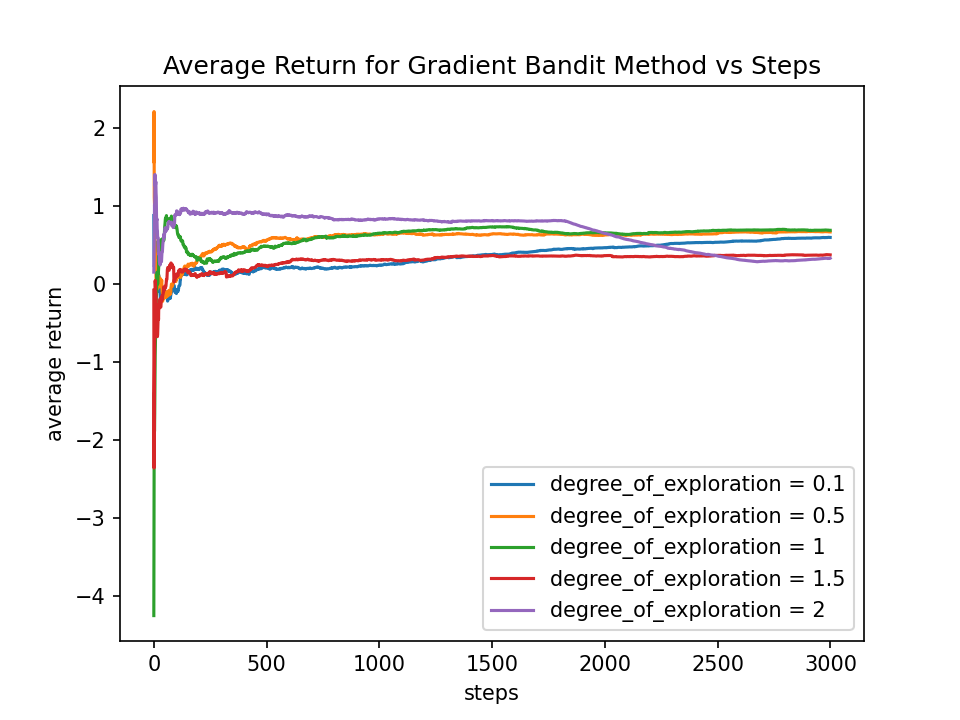

<IPython.core.display.Javascript object>


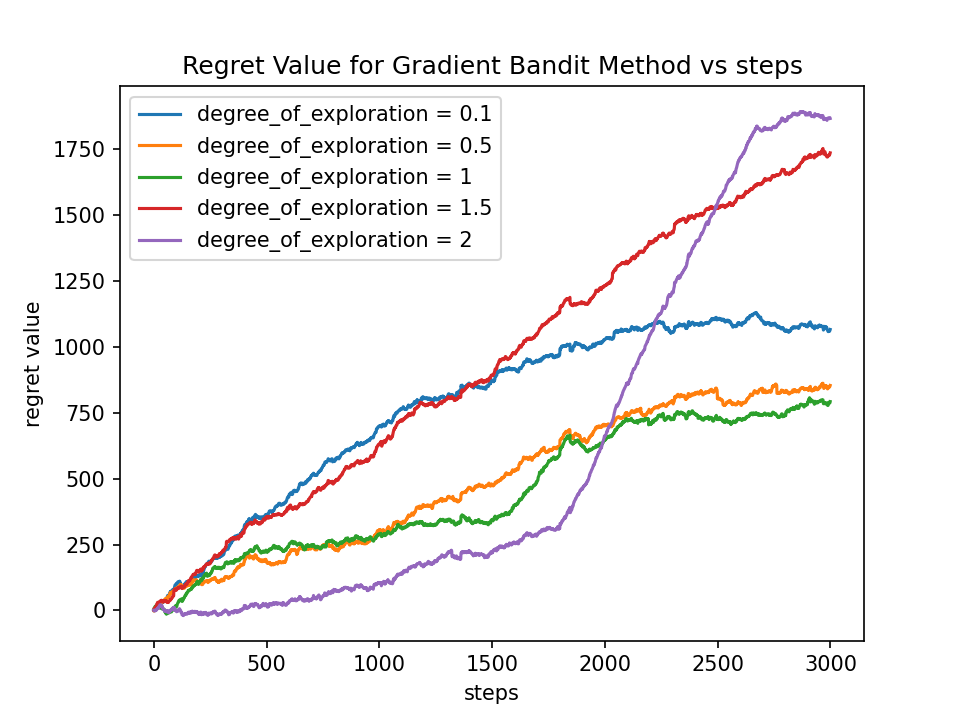

In [135]:
visualization_2(3000, 100)

Now we try to apply the methods developed above on the real stock data. The stock data are daily return for 12 stocks.

In [132]:
def get_real_stock_data():
    data = pd.read_excel('stock_data.xlsx').dropna()
    data.drop('Date', axis = 1, inplace = True)
    data = data.apply(lambda x: np.log(x + 1))
    data = data[np.isfinite(data).all(1)]
    display(data)
    display(data.mean(axis = 0))
    display(data.cov())
    return data, list(data.mean(axis = 0)), len(data.index), len(data.columns)

Note that the variance of each stock is much smaller than the mean. Then we try to apply $\epsilon$-greedy algorithm with $\epsilon = 0.1$ and UCB1 algorithm on these stock data.

In [136]:
def real_stock_data_training():
    stock_return, stock_mean_returns, m, n = get_real_stock_data()
    stock_returns = np.transpose(stock_return.to_numpy())
    plt.figure(7)
    plt.hist(stock_returns[0], bins = 'auto')
    plt.show()
    
    display(len(stock_returns))
    optimal_stock = get_optimal_price(stock_mean_returns)
    display(len(stock_returns[0]))
    epsilon = 0.1
    steps = list(range(m))
    standard_deviation = 1
    
    annualized_return = []
    average_return_1, regret_value_1, cummulative_return_1 = epsilon_greedy(m, epsilon, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)
    annualized_return.append(round((math.exp(average_return_1[-1]*253) - 1)*100, 2))
    average_return_2, regret_value_2, cummulative_return_2 = ucb(m, 1, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)
    annualized_return.append(round((math.exp(average_return_2[-1]*253) - 1)*100, 2))
    average_return_3, regret_value_3, cummulative_return_3 = epsilon_greedy(m, epsilon, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock, constant_step = 20)
    annualized_return.append(round((math.exp(average_return_3[-1]*253) - 1)*100, 2))
    average_return_4, regret_value_4, cummulative_return_4 = gradient(m, 1, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)
    annualized_return.append(round((math.exp(average_return_4[-1]*253) - 1)*100, 2))
    
    plt.figure(8)
    plt.plot(steps, average_return_1, label = 'epsilon-greedy-stationary')
    plt.plot(steps, average_return_2, label = 'UCB1')
    plt.plot(steps, average_return_3, label = 'epsilon-greedy-nonstationary')
    plt.plot(steps, average_return_4, label = 'gradient-bandit')
    plt.title('Average Return vs Steps')
    plt.xlabel('steps')
    plt.ylabel('average return')
    plt.legend()
    
    plt.figure(9)
    plt.plot(steps, regret_value_1, label = 'epsilon-greedy-stationary')
    plt.plot(steps, regret_value_2, label = 'UCB1')
    plt.plot(steps, regret_value_3, label = 'epsilon-greedy-nonstationary')
    plt.plot(steps, regret_value_4, label = 'gradient-bandit')
    plt.title('Regret Value vs Steps')
    plt.xlabel('steps')
    plt.ylabel('regret value')
    plt.legend()
    
    plt.figure(10)
    plt.plot(steps, np.exp(cummulative_return_1), label = 'epsilon-greedy-stationary')
    plt.plot(steps, np.exp(cummulative_return_2), label = 'UCB1')
    plt.plot(steps, np.exp(cummulative_return_3), label = 'epsilon-greedy-nonstationary')
    plt.plot(steps, np.exp(cummulative_return_4), label = 'gradient-bandit')
    plt.title('Cummulative Return vs Steps')
    plt.xlabel('steps')
    plt.ylabel('cummulative return')
    plt.legend()
    plt.show()
    
    methods = ['epsilon-greedy-stationary', 'UCB1', 'epsilon-greedy-nonstationary', 'gradient-bandit']
    daily_return_1 = pd.DataFrame({'return': cummulative_return_1}).pct_change()
    daily_return_2 = pd.DataFrame({'return': cummulative_return_2}).pct_change()
    daily_return_3 = pd.DataFrame({'return': cummulative_return_3}).pct_change()
    daily_return_4 = pd.DataFrame({'return': cummulative_return_4}).pct_change()
    volatility = [daily_return_1.std()['return'], daily_return_2.std()['return'], daily_return_3.std()['return'], daily_return_4.std()['return']]
    sharpe = [annualized_return[i]/(math.sqrt(253)*volatility[i]) for i in range(4)]
    annualized_return_df = pd.DataFrame({'method': methods, 'annualized return %': annualized_return, 'volatility': volatility, 'sharpe ratio': sharpe})
    display(annualized_return_df)

,^DJI,NFLX,FB,GOOG,AMZN,AXP,AAPL,BA,JPM,MSFT,GS,RCL
1,-0.018755,-0.052238,-0.016192,-0.021066,-0.020731,-0.026802,-0.028576,-0.006950,-0.031537,-0.009238,-0.031721,-0.015062
2,-0.007456,-0.017269,-0.013565,-0.023450,-0.023098,-0.021542,0.000094,-0.011848,-0.026271,-0.014786,-0.020437,0.002933
3,0.012180,0.005178,0.000000,-0.001715,0.010544,0.021605,0.013925,0.015406,0.001525,0.012625,0.014793,0.015018
4,0.018221,0.021946,0.026309,0.003148,0.006813,0.014075,0.037703,0.017528,0.022101,0.028994,0.015839,0.015742
5,-0.009567,-0.015578,-0.005644,-0.013035,-0.011818,-0.012747,0.001072,-0.001975,-0.017540,-0.008441,-0.015465,-0.007006
...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0.003383,-0.011343,-0.000582,-0.000556,0.003632,-0.010229,0.016187,0.028700,-0.000292,0.000000,0.000699,0.017544
1253,-0.001264,0.000300,-0.005154,-0.003922,-0.002116,0.002006,0.000950,-0.013571,0.002766,-0.000191,0.003573,-0.003304
1254,0.003708,-0.001712,0.012933,0.012456,0.043506,0.005357,0.019646,-0.009292,0.010556,0.008163,0.005638,0.009059
1255,0.000834,-0.010700,0.001491,-0.006275,0.000551,-0.001756,-0.000379,0.000667,0.000719,0.001826,-0.002382,-0.006280


^DJI    0.000372
NFLX    0.001489
FB      0.000762
GOOG    0.000746
AMZN    0.001425
AXP     0.000293
AAPL    0.000848
BA      0.000841
JPM     0.000739
MSFT    0.001053
GS      0.000193
RCL     0.000471
dtype: float64

,^DJI,NFLX,FB,GOOG,AMZN,AXP,AAPL,BA,JPM,MSFT,GS,RCL
^DJI,0.000073,0.000099,0.000074,0.000078,0.000085,0.000072,0.000086,0.000094,0.000087,0.000090,0.000097,0.000086
NFLX,0.000099,0.000676,0.000190,0.000185,0.000234,0.000104,0.000152,0.000126,0.000105,0.000170,0.000130,0.000158
FB,0.000074,0.000190,0.000320,0.000161,0.000187,0.000070,0.000129,0.000091,0.000079,0.000135,0.000096,0.000102
GOOG,0.000078,0.000185,0.000161,0.000226,0.000178,0.000074,0.000124,0.000088,0.000083,0.000146,0.000100,0.000108
AMZN,0.000085,0.000234,0.000187,0.000178,0.000334,0.000079,0.000142,0.000102,0.000086,0.000168,0.000104,0.000127
AXP,0.000072,0.000104,0.000070,0.000074,0.000079,0.000170,0.000073,0.000080,0.000101,0.000085,0.000111,0.000100
AAPL,0.000086,0.000152,0.000129,0.000124,0.000142,0.000073,0.000246,0.000102,0.000090,0.000132,0.000108,0.000116
BA,0.000094,0.000126,0.000091,0.000088,0.000102,0.000080,0.000102,0.000254,0.000100,0.000098,0.000112,0.000111
JPM,0.000087,0.000105,0.000079,0.000083,0.000086,0.000101,0.000090,0.000100,0.000175,0.000095,0.000165,0.000111
MSFT,0.000090,0.000170,0.000135,0.000146,0.000168,0.000085,0.000132,0.000098,0.000095,0.000215,0.000108,0.000112


<IPython.core.display.Javascript object>


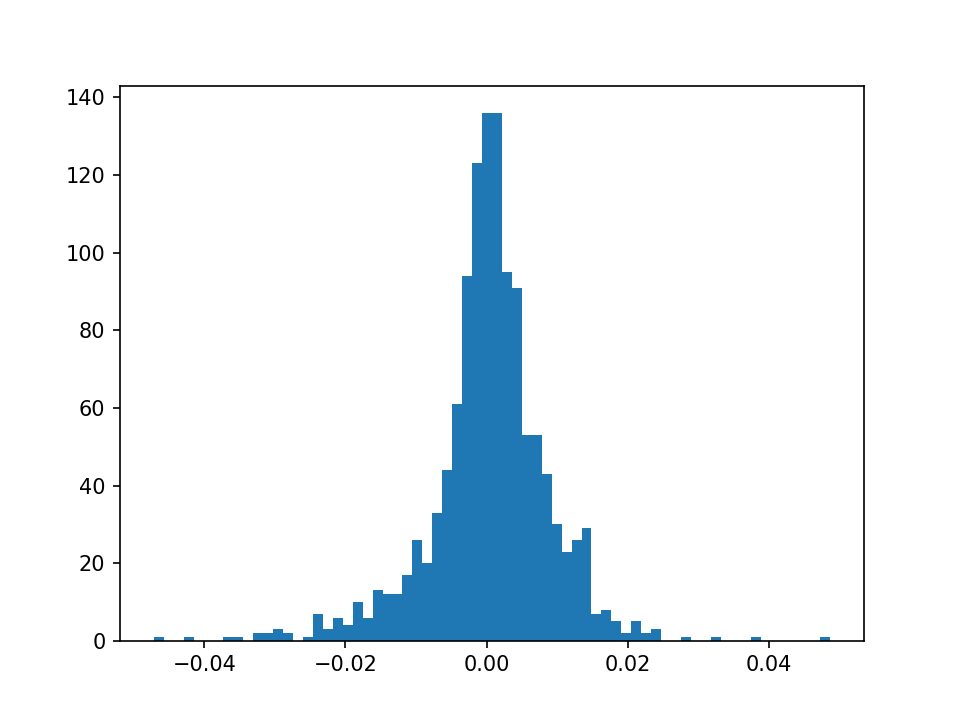

12

1256

<IPython.core.display.Javascript object>


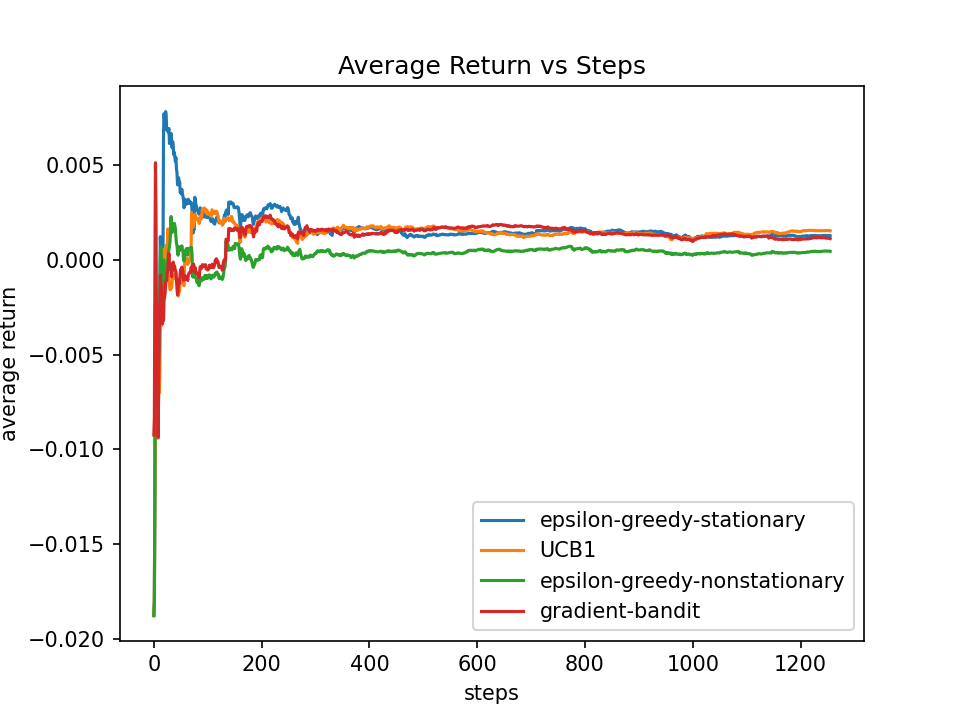

<IPython.core.display.Javascript object>


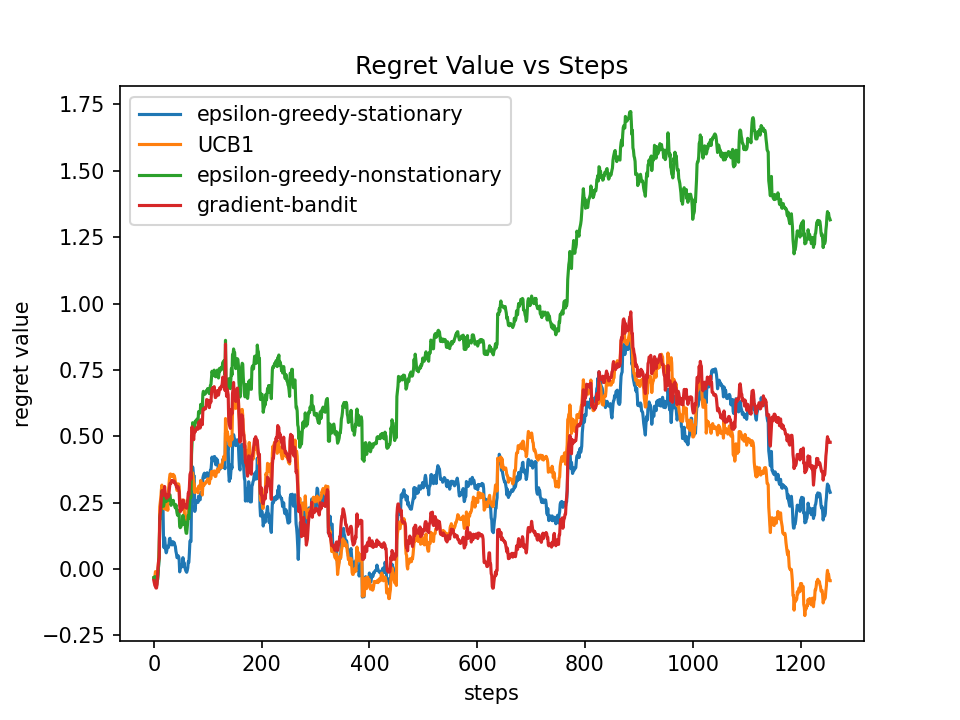

<IPython.core.display.Javascript object>


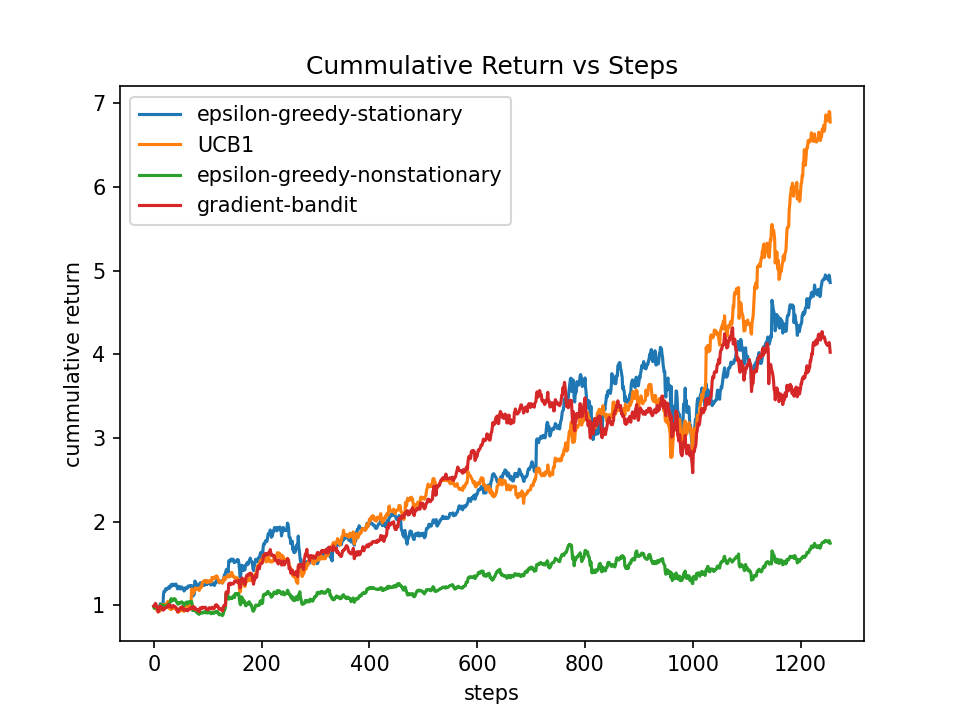

,method,annualized return %,volatility,sharpe ratio
0,epsilon-greedy-stationary,37.49,1.672975,1.408853
1,UCB1,47.03,1.077233,2.744765
2,epsilon-greedy-nonstationary,11.82,9.243573,0.080393
3,gradient-bandit,32.37,1.141726,1.782462


In [137]:
real_stock_data_training()

Seems like UCB1 method performs better than other methods as the mean of stock price is not stationary. 